In [1]:
import importlib

import ase.io as aio
from ase.units import Bohr
import numpy as np
import glob

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import bt_tools as bt
importlib.reload(bt)

import utils_qm as uqm

from matplotlib import pyplot as plt

def ref_scatter(ref):
    return(np.linspace(np.amin(ref), np.amax(ref), 3))

### calculate effective core charge

In [2]:
weighted_core = lambda Ne, Zs, Zp: 2*Zs/Ne + (Ne-2)/Ne*Zp

zs2 = np.array([3.217, 3.847, 4.492, 5.128])
zp2 = np.array([3.136, 3.834, 4.453, 5.100])

zs3 = np.array([4.903, 	5.642, 	6.367, 	7.068])
zp3 = np.array([4.285, 4.886, 5.482, 6.116])

zs4 = np.array([8.044, 	8.944, 	9.758, 	10.553])
zp4 = np.array([6.780, 7.449, 8.287, 9.028])

zs = [zs2, zs3, zs4]
zp = [zp2, zp3, zp4]
ne = [4, 5, 6, 7]
z_eff = []
for rs, rp in zip(zs, zp):
    zr = []
    for s, p, n in zip(rs, rp, ne):
        zr.append(weighted_core(n, s, p))
    z_eff.append(zr)
    
# z_eff = [[6, 7, 8, 9], [14, 15, 16, 17], [32, 33, 34, 35]]
# z_eff = [zp2, zp3, zp4]

In [3]:
z_eff

[[3.1765, 3.8392, 4.466, 5.108],
 [4.593999999999999, 5.1884, 5.776999999999999, 6.388],
 [7.412000000000001, 8.047, 8.777333333333333, 9.463714285714287]]

## optimize with effective core charges

In [19]:
importlib.reload(bt)

def comp_dist2(var, alpha, beta, b_prime, a, b):
    Z1, Z2, d = var.T
    comp = (-beta*(Z1**(7/3)+Z2**(7/3))+alpha-b_prime*Z1*Z2)
    dist = a/d+b#+b/d+c
    return(comp*dist)

def comp_gamma_dist2(var, alpha, beta, gamma, b_prime, a, b):
    Z1, Z2, d = var.T
    comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1*Z2
    dist = a/d+b#/d+c
    return(comp*dist)

def comp_dist3(var, alpha, beta, gamma, b_prime, a, b):
    Z1, Z2, d = var.T
    comp = alpha-(b_prime**2)*Z1*Z2
    dist = a/d+b#/d+c
    return(comp*dist)


def comp(var, alpha, beta, b_prime, a, b):
    Z1, Z2, d = var.T
    comp = (-beta*(Z1**(7/3)+Z2**(7/3))+alpha-b_prime*Z1*Z2)

    return(comp)

def comp_gamma(var, alpha, beta, gamma, b_prime, a, b):
    Z1, Z2, d = var.T
    comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1*Z2
    return(comp)

<ipython-input-19-6df946843e96>:11: RuntimeWarning: overflow encountered in power
  comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1*Z2
<ipython-input-19-6df946843e96>:30: RuntimeWarning: overflow encountered in power
  comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1*Z2
/home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


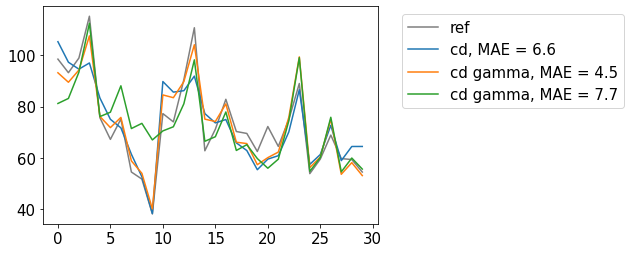

In [20]:
e2 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/energies_single.txt')
e3 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_3/energies_single.txt')
e4 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/energies_single.txt')

nuc_charges = [[6,7,8,9], [14, 15, 16, 17], [32, 33, 34, 35]]

for e, z in zip([e2, e3, e4], z_eff):
    e_nuc = []
    for i in range(len(z)):
        for j in range(i, len(z)):
            e_nuc.append(z[i]*z[j])
#             e_nuc.append(0.0)

    e_nuc = np.array(e_nuc)
    e_el = (e[:,0] - e_nuc).copy()
    e[:,1] = e_el
    e[:,2] = e_nuc

distances = np.array([10*[1.42] + 10*[2.12] + 10*[2.36]])
distances /= Bohr

energies = np.concatenate((e2, e3, e4), axis = 0)

b_zeff = bt.BDE_dist(energies, z_eff, distances)

b_zeff.fit(comp_dist2)
cd_mae = b_zeff.mae.copy()
bde_cd = b_zeff.bde_fitted.copy()

b_zeff.fit(comp_gamma_dist2)
# b_zeff.fit(comp_dist3)

cd_gamma_mae = b_zeff.mae.copy()
bde_cd_gamma = b_zeff.bde_fitted.copy()

b_zeff.fit(comp_gamma)


plt.plot(b_zeff.bde, label = 'ref', color = 'tab:grey')
plt.plot(bde_cd, label = f'cd, MAE = {np.round(cd_mae, 1)}')
plt.plot(bde_cd_gamma, label = f'cd gamma, MAE = {np.round(cd_gamma_mae, 1)}')

plt.plot(b_zeff.bde_fitted, label = f'cd gamma, MAE = {np.round(b_zeff.mae, 1)}')

plt.legend(bbox_to_anchor=(1.05, 1))

In [15]:
b_zeff.mae

10.01377900914237

In [9]:
b_zeff.params[0]

array([-18.28447484,   0.74411685,   1.41559886,   9.04977406,
        -0.09119457,   7.60799719])

In [6]:
coeffs['alpha'] = b_zeff.params[0][0]
coeffs['beta'] = b_zeff.params[0][1]
coeffs['gamma'] = 7/3
coeffs['bprime'] = b_zeff.params[0][2]
coeffs['a'] = b_zeff.params[0][3]
coeffs['b'] = b_zeff.params[0][4]

NameError: name 'coeffs' is not defined

In [ ]:
coeffs = {'alpha':0, 'beta':0, 'gamma':0, 'bprime':0, 'a':0, 'b':0}
for k, p in zip(coeffs.keys(), b_zeff.params[0]):
    coeffs[k] = p
    
coeffs['beta'] = coeffs['beta']**2
coeffs['gamma'] = coeffs['gamma']**2
coeffs['bprime'] = coeffs['bprime']**2

# uqm.save_obj(coeffs, '/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/modelA2')

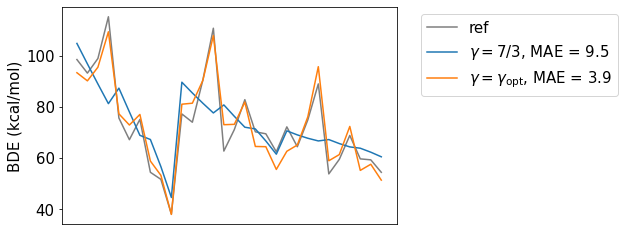

In [7]:
plt.rcParams['font.size'] = 15
plt.plot(b_zeff.bde, label = 'ref', color = 'tab:grey')
plt.plot(bde_cd, label = f'$\gamma = 7/3$, MAE = {np.round(cd_mae, 1)}')
plt.plot(bde_cd_gamma, label = r'$\gamma = \gamma_{\rm{opt}}$, MAE = ' + str(np.round(cd_gamma_mae, 1)))
plt.xticks([])
plt.ylabel(r'BDE (kcal/mol)')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.savefig('/home/sahre/work/bonding_trends/figures/zeff/model1ab.png', bbox_inches = 'tight')

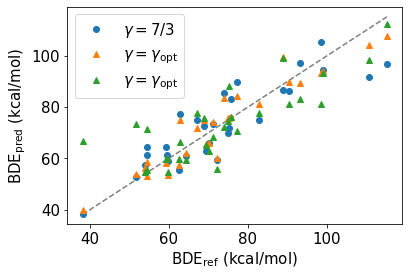

In [21]:
plt.rcParams['font.size'] = 15

plt.plot(ref_scatter(b_zeff.bde), ref_scatter(b_zeff.bde), '--', color = 'tab:grey')
# plt.plot(bde_cd, b_zeff.bde, 'o')
plt.plot(b_zeff.bde, bde_cd, 'o', label = '$\gamma = 7/3$')
plt.plot(b_zeff.bde,bde_cd_gamma, '^', label = r'$\gamma = \gamma_{\rm{opt}}$')
plt.plot(b_zeff.bde,b_zeff.bde_fitted, '^', label = r'$\gamma = \gamma_{\rm{opt}}$')

plt.xlabel(r'BDE$_{\rm{ref}}$ (kcal/mol)')
plt.ylabel(r'BDE$_{\rm{pred}}$ (kcal/mol)')
plt.legend()
plt.savefig('/home/sahre/work/bonding_trends/figures/zeff/model1ab_scatter.png', bbox_inches = 'tight')

## optimize $Z_\text{eff}$

In [ ]:
comp_gamma_dist2_flexible_zeff_lat = None

def comp_gamma_dist2_flexible_zeff(*args):
    globals()['comp_gamma_dist2_flexible_zeff_lat'] = args[1:]
    var = args[0]
    alpha, beta, gamma, b_prime, a, b = args[1:7]
    Zeffs = args[7:]
    lookup = [6,7,8,9,14,15,16,17,32,33,34,35]
    
    Z1, Z2, d = var.T
    Z1e = np.array([Zeffs[lookup.index(int(_))] for _ in Z1])
    Z2e = np.array([Zeffs[lookup.index(int(_))] for _ in Z2])
    comp = -beta**2*(Z1e**(gamma**2)+Z2e**(gamma**2))+alpha-(b_prime**2)*Z1e*Z2e
    dist = a/d+b#/d+c
    
    #print(args[1:])
    return(comp*dist)

In [ ]:
e2 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/energies_single.txt')
e3 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_3/energies_single.txt')
e4 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/energies_single.txt')

nuc_charges = [[6, 7, 8, 9], [14, 15, 16, 17], [32, 33, 34, 35]]


for e, z in zip([e2, e3, e4], z_eff):
    e_nuc = []
    for i in range(len(z)):
        for j in range(i, len(z)):
            e_nuc.append(z[i]*z[j])
    e_nuc = np.array(e_nuc)
    e_el = (e[:,0] - e_nuc).copy()
    e[:,1] = e_el
    e[:,2] = e_nuc

distances = np.array([10*[1.42] + 10*[2.12] + 10*[2.36]])
distances /= Bohr

energies = np.concatenate((e2, e3, e4), axis = 0)

nuc_charges = [[6, 7, 8, 9], [14, 15, 16, 17], [32, 33, 34, 35]]

# initial parameters
b_ini = bt.BDE_dist(energies, z_eff, distances)
b_ini.fit(comp_gamma_dist2)
alpha, beta, gamma, bprime, a, b = b_ini.params[0].copy()
p0 = np.array((alpha, np.sqrt(abs(beta)), np.sqrt(abs(gamma)), np.sqrt(abs(bprime)), a, b))
p0 = np.concatenate((p0, np.array(z_eff).flatten()))

# fitoptimizeoptimize
b_flexi_zeff = bt.BDE_dist(energies, nuc_charges, distances)
b_flexi_zeff.fit(comp_gamma_dist2_flexible_zeff, p0)

plt.rcParams['font.size'] = 15
plt.plot(b_flexi_zeff.bde)
plt.plot(b_flexi_zeff.bde_fitted, label = r'$Z_{\rm{eff, opt}}$, MAE = ' + str(np.round(b_flexi_zeff.mae, 2)))
plt.legend()

In [ ]:
plt.rcParams['font.size'] = 20
params = comp_gamma_dist2_flexible_zeff_lat
ebfe_flexi = comp_gamma_dist2_flexible_zeff(*(b_flexi_zeff.xdata, *params))
bde_flexi = -(ebfe_flexi+b_flexi_zeff.nbfe)

mae_flexi = np.abs(bde_flexi-b_flexi_zeff.bde).mean()

plt.rcParams['font.size'] = 15
plt.plot(b_flexi_zeff.bde, color = 'tab:grey', label = 'ref')
plt.plot(bde_flexi, label = r'$Z_{\rm{eff, opt}}$, MAE = ' + str(np.round(mae_flexi, 2)))
# plt.legend(loc = 'lower right', framealpha = 0.0)
plt.xticks([])
plt.ylabel(r'BDE (kcal/mol)')
# plt.legend(bbox_to_anchor=(1.05, 1))
plt.legend(edgecolor=(0, 0, 0, 1.), framealpha = 0.0, loc = 'lower right')
# plt.savefig('/home/sahre/work/bonding_trends/figures/zeff/model2a.png', bbox_inches = 'tight')

In [ ]:
plt.plot(np.array(nuc_charges).flatten(), params[6:], '-o')
plt.xlabel(r'$Z$')
plt.ylabel(r'$Z_{\rm{opt}}$')
# plt.plot(np.array(nuc_charges).flatten(), params[6:], '-o')

plt.savefig('/home/sahre/work/bonding_trends/figures/zeff/Z_ZeffB.png', bbox_inches = 'tight')

In [ ]:
# coeffs = {'alpha':0, 'beta':0, 'gamma':0, 'bprime':0, 'a':0, 'b':0}
# for k, p in zip(coeffs.keys(), params[:6]):
#     coeffs[k] = p
    
# coeffs['beta'] = coeffs['beta']**2
# coeffs['gamma'] = coeffs['gamma']**2
# coeffs['bprime'] = coeffs['bprime']**2

# uqm.save_obj(coeffs, '/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/modelB')

In [ ]:
plt.rcParams['font.size'] = 20

plt.plot(ref_scatter(b_flexi_zeff.bde), ref_scatter(b_flexi_zeff.bde), '--', color = 'tab:grey')

plt.plot(b_flexi_zeff.bde, bde_flexi, 'o')


plt.xlabel(r'BDE$_{\rm{ref}}$ (kcal/mol)')
plt.ylabel(r'BDE$_{\rm{pred}}$ (kcal/mol)')
plt.savefig('/home/sahre/work/bonding_trends/figures/zeff/model2a_scatter.png', bbox_inches = 'tight')

## optimize $Z_\text{eff}$ a la Guido

In [ ]:
def comp_gamma_dist2(var, alpha, beta, gamma, b_prime, a, b):
    Z1, Z2, d = var.T
    comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1*Z2
    dist = a/d+b#/d+c
    return(comp*dist)

# def comp_gamma_dist2(var, alpha, beta, gamma, b_prime, a, b):
#     Z1, Z2, d = var.T
#     comp = -beta*(Z1**(gamma)+Z2**(gamma))+alpha-(b_prime)*Z1*Z2
#     dist = a/d+b#/d+c
#     return(comp*dist)

def comp_gamma_dist2_flexible_zeff2(*args):
    globals()['comp_gamma_dist2_flexible_zeff_lat'] = args[1:]
    var = args[0]
    alpha, beta, gamma, b_prime, a, b = args[1:7]
    Zeffs = args[7:]
    lookup = [6,7,8,9,14,15,16,17,32,33,34,35]
    
    Z1, Z2, d = var.T
    Z1e = np.array([Zeffs[lookup.index(int(_))] for _ in Z1])
    Z2e = np.array([Zeffs[lookup.index(int(_))] for _ in Z2])
    comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1e*Z2e
    dist = a/d+b#/d+c
    
    #print(args[1:])
    return(comp*dist)

In [ ]:
def key2(x):
    pattern_list = ['CC', 'CN', 'CO', 'CF', 'NN', 'NO', 'NF', 'OO', 'OF', 'FF']
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)
def key3(x):
    pattern_list = ['SiSi', 'SiP','SiS','SiCl','PP','PS','PCl','SS','SCl','ClCl',]
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)
def key4(x):
    pattern_list = ['[GeH3][GeH3]', '[GeH3][AsH2]', '[GeH3][SeH]', '[GeH3]Br', '[AsH2][AsH2]', '[AsH2][SeH]', '[AsH2]Br', '[SeH][SeH]', '[SeH]Br', 'BrBr']
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)

dist_exact2 = bt.get_distances('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/diatomics_single/*_opt.xyz', key2)
dist_exact3 = bt.get_distances('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_3/diatomics_single/*_opt.xyz', key3)
dist_exact4 = bt.get_distances('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/diatomics_single/*_opt.xyz', key4)
dist_exact = np.concatenate((dist_exact2, dist_exact3, dist_exact4))
dist_exact = np.reshape(dist_exact, (1,30))

In [ ]:
e2 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/energies_single.txt')
e3 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_3/energies_single.txt')
e4 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/energies_single.txt')

nuc_charges = [[6, 7, 8, 9], [14, 15, 16, 17], [32, 33, 34, 35]]

for e, z in zip([e2, e3, e4], nuc_charges):
    e_nuc = []
    for i in range(len(z)):
        for j in range(i, len(z)):
            e_nuc.append(z[i]*z[j])
    e_nuc = np.array(e_nuc)
    e_el = (e[:,0] - e_nuc).copy()
    e[:,1] = e_el
    e[:,2] = e_nuc

# for e, d, z in zip([e2, e3, e4], [dist_exact2, dist_exact3, dist_exact4], z_eff):
#     e_nuc = []
#     for i in range(len(z)):
#         for j in range(i, len(z)):
#             e_nuc.append(z[i]*z[j])
#     e_nuc = np.array(e_nuc)/d
#     e_el = (e[:,0] - e_nuc).copy()
#     e[:,1] = e_el
#     e[:,2] = e_nuc

distances = dist_exact
# distances = np.array([10*[1.42] + 10*[2.12] + 10*[2.36]])
distances /= Bohr

energies = np.concatenate((e2, e3, e4), axis = 0)


# initial parameters
b_ini = bt.BDE_dist(energies, z_eff, distances)
b_ini.fit(comp_gamma_dist2)
alpha, beta, gamma, bprime, a, b = b_ini.params[0].copy()
# p0 = np.array((alpha, np.sqrt(abs(beta)), np.sqrt(abs(gamma)), np.sqrt(abs(bprime)), a, b))
p0 = np.array((alpha, beta, gamma, bprime, a, b))

p0 = np.concatenate((p0, np.array(z_eff).flatten()))

# fit optimize
b_flexi_zeff = bt.BDE_dist(energies, nuc_charges, distances)
b_flexi_zeff.fit(comp_gamma_dist2_flexible_zeff2, p0)

plt.rcParams['font.size'] = 15
plt.plot(b_flexi_zeff.bde)
plt.plot(b_flexi_zeff.bde_fitted, label = r'$Z_{\rm{eff, opt}}$, MAE = ' + str(np.round(b_flexi_zeff.mae, 2)))
plt.legend()



In [ ]:
b_flexi_zeff.params[0]

In [ ]:
# coeffs = {'alpha':0, 'beta':0, 'gamma':0, 'bprime':0, 'a':0, 'b':0}
# for k, p in zip(coeffs.keys(), b_flexi_zeff.params[0]):
#     coeffs[k] = p
    
# coeffs['beta'] = coeffs['beta']**2
# coeffs['gamma'] = coeffs['gamma']**2
# coeffs['bprime'] = coeffs['bprime']**2

# uqm.save_obj(coeffs, '/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/modelC')

In [ ]:
plt.rcParams['font.size'] = 15
plt.plot(b_flexi_zeff.bde, color = 'tab:grey', label = 'ref')
plt.plot(b_flexi_zeff.bde_fitted, label = r'$Z_{\rm{eff, opt}}$, MAE = ' + str(np.round(b_flexi_zeff.mae, 2)))
# plt.legend(loc = 'lower right', framealpha = 0.0)
plt.xticks([])
plt.ylabel(r'BDE (kcal/mol)')
# plt.legend(bbox_to_anchor=(1.05, 1))
plt.legend(edgecolor=(0, 0, 0, 1.), framealpha = 0.0, loc = 'lower right')

# plt.savefig('/home/sahre/work/bonding_trends/figures/zeff/model3a.png', bbox_inches = 'tight')

In [ ]:
# params = comp_gamma_dist2_flexible_zeff_lat
# ebfe_flexi = comp_gamma_dist2_flexible_zeff2(*(b_flexi_zeff.xdata, *params))
# bde_flexi = -(ebfe_flexi+b_flexi_zeff.nbfe)

# mae_flexi = np.abs(bde_flexi-b_flexi_zeff.bde).mean()

# plt.rcParams['font.size'] = 15
# plt.plot(b_flexi_zeff.bde)
# plt.plot(bde_flexi, label = r'$Z_{\rm{eff, opt}}$, MAE = ' + str(np.round(mae_flexi, 2)))
# plt.legend()

In [ ]:
plt.rcParams['font.size'] = 20

plt.plot(ref_scatter(b_flexi_zeff.bde), ref_scatter(b_flexi_zeff.bde), '--', color = 'tab:grey')

plt.plot(b_flexi_zeff.bde, b_flexi_zeff.bde_fitted, 'o')


plt.xlabel(r'BDE$_{\rm{ref}}$ (kcal/mol)')
plt.ylabel(r'BDE$_{\rm{pred}}$ (kcal/mol)')
# plt.savefig('/home/sahre/work/bonding_trends/figures/zeff/model3a_scatter.png', bbox_inches = 'tight')

In [ ]:
plt.plot(np.array(nuc_charges).flatten(), b_flexi_zeff.params[0][6:], '-o')
# plt.plot(np.array(nuc_charges).flatten(), params[6:], '-o')

plt.xlabel(r'$Z$')
plt.ylabel(r'$Z_{\rm{opt}}$')
# plt.plot(np.array(nuc_charges).flatten(), params[6:], '-o')

# plt.savefig('/home/sahre/work/bonding_trends/figures/zeff/Z_ZeffC.png', bbox_inches = 'tight')

In [ ]:
b_flexi_zeff.params[0]

In [ ]:
n_core = [2,2,2,2,10, 10, 10, 10, 28, 28, 28, 28]
n_val = [4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7]
# def z_eff_fit(*args):
#     nc, nv = args[0]
#     bprime, q, p = args[1:]
#     return(bprime*(p*nc + q*nv))

def z_eff_fit(*args):
    nc, nv = args[0]
    q, p = args[1:]
    return((p*nc + q*nv))

from scipy.optimize import curve_fit

xdata = np.array([n_core, n_val])
param, qof = curve_fit(f=z_eff_fit,xdata=xdata, ydata=b_flexi_zeff.params[0][6:], p0=[1,1])

In [ ]:
args = (xdata, *param)
# args = (xdata, 0.1944911 , 0.19331392)

In [ ]:
from scipy.stats import linregress
linregress(np.array(nuc_charges).flatten(), b_flexi_zeff.params[0][6:])

In [ ]:
plt.plot(np.array(nuc_charges).flatten(), z_eff_fit(*args), '-o')

In [ ]:
plt.plot(b_flexi_zeff.params[0][6:], 'o')

plt.plot(z_eff_fit(*args), 'o')

plt.plot(np.array(nuc_charges).flatten()*0.19374316270721906+0.007939353154243545, 'o')

In [ ]:
b_flexi_zeff.params[0][6:]-z_eff_fit(*args)

### Fit for $Z_\text{eff}$

In [29]:
def comp_gamma_dist2(var, alpha, beta, gamma, b_prime, a, b):
    Z1, Z2, d = var.T
    comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1*Z2
    dist = a/d+b
    return(comp*dist)

# def comp_gamma_dist2(var, alpha, beta, gamma, b_prime, a, b):
#     Z1, Z2, d = var.T
#     comp = -beta*(Z1**(gamma)+Z2**(gamma))+alpha-(b_prime)*Z1*Z2
#     dist = a/d+b#/d+c
#     return(comp*dist)

def comp_gamma_dist2_flexible_zeff2(*args):
    globals()['comp_gamma_dist2_flexible_zeff_lat'] = args[1:]
    var = args[0]
    alpha, beta, gamma, b_prime, a, b = args[1:7]
    Zeffs = args[7:]
    lookup = [6,7,8,9,14,15,16,17,32,33,34,35]
    
    Z1, Z2, d = var.T
    Z1e = np.array([Zeffs[lookup.index(int(_))] for _ in Z1])
    Z2e = np.array([Zeffs[lookup.index(int(_))] for _ in Z2])
    comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1e*Z2e
    dist = a/d+b
    return(comp*dist)

def comp_gamma_dist2_ncnv(*args):
    globals()['comp_gamma_dist2_flexible_zeff_lat'] = args[1:]
    var = args[0]
    alpha, beta, gamma, bprime, p, q, a, b = args[1:]
    
    Z1, Z2, d = var.T
    
    lookup = [6,7,8,9,14,15,16,17,32,33,34,35]
    n_core = [2,2,2,2,10, 10, 10, 10, 28, 28, 28, 28]
    n_val = [4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7]
    
#     nc1 = np.array([n_core[lookup.index(int(_))] for _ in Z1])
#     nv1 = np.array([n_val[lookup.index(int(_))] for _ in Z2])
    
#     nc2 = np.array([n_core[lookup.index(int(_))] for _ in Z1])
#     nv2 = np.array([n_val[lookup.index(int(_))] for _ in Z2])
        
    comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-bprime**2*(p*Z1+q)*(p*Z2+q)
    dist = a/d+b
    return(comp*dist)

In [30]:
def key2(x):
    pattern_list = ['CC', 'CN', 'CO', 'CF', 'NN', 'NO', 'NF', 'OO', 'OF', 'FF']
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)
def key3(x):
    pattern_list = ['SiSi', 'SiP','SiS','SiCl','PP','PS','PCl','SS','SCl','ClCl',]
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)
def key4(x):
    pattern_list = ['[GeH3][GeH3]', '[GeH3][AsH2]', '[GeH3][SeH]', '[GeH3]Br', '[AsH2][AsH2]', '[AsH2][SeH]', '[AsH2]Br', '[SeH][SeH]', '[SeH]Br', 'BrBr']
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)

dist_exact2 = bt.get_distances('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/diatomics_single/*_opt.xyz', key2)
dist_exact3 = bt.get_distances('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_3/diatomics_single/*_opt.xyz', key3)
dist_exact4 = bt.get_distances('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/diatomics_single/*_opt.xyz', key4)
dist_exact = np.concatenate((dist_exact2, dist_exact3, dist_exact4))
dist_exact = np.reshape(dist_exact, (1,30))

In [31]:
e2 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/energies_single.txt')
e3 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_3/energies_single.txt')
e4 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/energies_single.txt')

nuc_charges = np.array([[6, 7, 8, 9], [14, 15, 16, 17], [32, 33, 34, 35]])

for e, z in zip([e2, e3, e4], z_eff):
    e_nuc = []
    for i in range(len(z)):
        for j in range(i, len(z)):
            e_nuc.append(z[i]*z[j])
    e_nuc = np.array(e_nuc)
    e_el = (e[:,0] - e_nuc).copy()
    e[:,1] = e_el
    e[:,2] = e_nuc

distances = dist_exact
# distances = np.array([10*[1.42] + 10*[2.12] + 10*[2.36]])
distances /= Bohr

energies = np.concatenate((e2, e3, e4), axis = 0)


# initial parameters
b_ini = bt.BDE_dist(energies, z_eff, distances)
b_ini.fit(comp_gamma_dist2)
alpha, beta, gamma, bprime, a, b = b_ini.params[0].copy()
# p0 = np.array((alpha, np.sqrt(abs(beta)), np.sqrt(abs(gamma)), np.sqrt(abs(bprime)), a, b))
p0 = np.array((alpha, beta, gamma, bprime, a, b))

p0 = np.concatenate((p0, np.array(z_eff).flatten()))

# fit optimize

b_flexi_zeff = bt.BDE_dist(energies, nuc_charges, distances)

# p0 = (b_flexi_zeff.xdata, 6.63789067e+01, -6.89399512e-05,  2.11811554e+00,  -9.54267972e+01, 0.19332623842045737, 0.006242525668592069,
#         4.88038233e-02,  4.91408751e+00)
# p0 = (6.63789067e+01, -6.89399512e-05,  2.11811554e+00,  -9.54267972e+01, 4.88038233e-02,  4.91408751e+00)
# p0 = np.concatenate((p0, np.array(z_eff).flatten()))

b_flexi_zeff.fit(comp_gamma_dist2_flexible_zeff2, p0)

<ipython-input-29-116a0f3dc819>:3: RuntimeWarning: overflow encountered in power
  comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1*Z2


In [32]:
b_flexi_zeff.params[0]

array([4.06542610e+01, 1.73141091e-01, 1.75357211e+00, 1.63285734e+01,
       7.88236150e-03, 2.44911290e+00, 3.15769966e+00, 3.79226558e+00,
       4.39554437e+00, 5.01606049e+00, 4.45689565e+00, 5.02714200e+00,
       5.59436902e+00, 6.18208296e+00, 6.60832652e+00, 7.22244499e+00,
       7.93747794e+00, 8.60187337e+00])

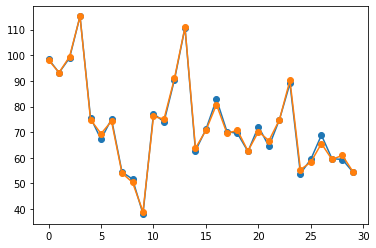

In [33]:
plt.plot(b_flexi_zeff.bde, '-o')
plt.plot(b_flexi_zeff.bde_fitted, '-o')

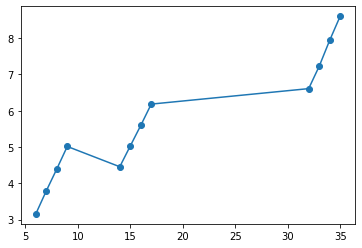

In [8]:
plt.plot(nuc_charges.flatten(), b_flexi_zeff.params[0][6:], '-o')

#### fit Z to Z_eff

In [21]:
from scipy.optimize import curve_fit
from scipy.stats import linregress

In [15]:
n_core = np.array([2, 2, 2, 2, 10, 10, 10, 10, 28, 28, 28, 28])
n_val = np.array([4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7])

def z_eff_fit(*args):
    nc, nv = args[0]
    q, p = args[1:]
    return((p*nc + q*nv))


xdata = np.array([n_core, n_val])
param, qof = curve_fit(f=z_eff_fit, xdata=xdata, ydata=b_flexi_zeff.params[0][6:], p0=[1,1])

In [22]:
linregress(nuc_charges[0], b_flexi_zeff.params[0][6:10])

LinregressResult(slope=0.617836129618967, intercept=-0.5433784484652229, rvalue=0.9999562326382998, pvalue=4.376736170019768e-05, stderr=0.004087546832774631, intercept_stderr=0.03099535850465744)

In [23]:
linregress(nuc_charges[1], b_flexi_zeff.params[0][10:14])

LinregressResult(slope=0.5742788956973375, intercept=-3.586200474554393, rvalue=0.9999684952553282, pvalue=3.150474467183974e-05, stderr=0.003223451206447706, intercept_stderr=0.05009330294365032)

In [26]:
linregress(nuc_charges[2], b_flexi_zeff.params[0][14:18])

LinregressResult(slope=0.6695673512584187, intercept=-14.837975561353968, rvalue=0.9996031222289564, pvalue=0.0003968777710435799, stderr=0.013342953043645142, intercept_stderr=0.44723779337355507)

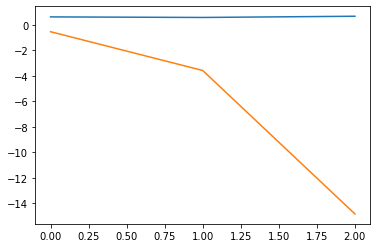

In [28]:
plt.plot([0.617836129618967, 0.5742788956973375, 0.6695673512584187])

plt.plot([-0.5433784484652229, -3.586200474554393, -14.837975561353968])

In [ ]:
def comp_gamma_dist2_flexible_zeff2(*args):
    globals()['comp_gamma_dist2_flexible_zeff_lat'] = args[1:]
    var = args[0]
    alpha, beta, gamma, b_prime, a, b = args[1:7]
    Zeffs = args[7:]
    lookup = [6,7,8,9,14,15,16,17,32,33,34,35]
    
    Z1, Z2, d = var.T
    Z1e = np.array([Zeffs[lookup.index(int(_))] for _ in Z1])
    Z2e = np.array([Zeffs[lookup.index(int(_))] for _ in Z2])
    comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1e*Z2e
    dist = a/d+b

    return(comp*dist)

p0 = (b_flexi_zeff.xdata, 6.63789067e+01, -6.89399512e-05,  2.11811554e+00,  5.83172093e+01,
        4.88038233e-02,  4.91408751e+00,  1.17371392e+00,  1.36540376e+00,
        1.55771761e+00,  1.75033771e+00,  2.71963807e+00,  2.91292869e+00,
        3.10635172e+00,  3.29988289e+00,  6.20818002e+00,  6.40208393e+00,
        6.59563487e+00,  6.78935382e+00)

p1 = (b_flexi_zeff.xdata, 6.63789067e+01, -6.89399512e-05,  2.11811554e+00,  5.83172093e+01,
        4.88038233e-02,  4.91408751e+00,  1.16619996, 1.35952619, 1.55285243, 1.74617867, 2.71280986,
       2.9061361 , 3.09946234, 3.29278858, 6.19268216, 6.38600839,
       6.57933463, 6.77266087)

In [ ]:
plt.plot(-(comp_gamma_dist2_flexible_zeff2(*p0)+b_flexi_zeff.nbfe))

# plt.plot(-(comp_gamma_dist2_flexible_zeff2(*p1)+b_flexi_zeff.nbfe))